In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [77]:
dataset = pd.read_csv('ml_data/ml_train_data_100.csv', index_col=0)
file_list = ['414','415','474','500','500(1)','500(2)','442','287','200']
for file in file_list:
    read_f = pd.read_csv(f'ml_data/ml_train_data{file}.csv', index_col=0)
    dataset=pd.concat([dataset, read_f],ignore_index=True)
dataset = dataset[dataset['meg3-rna_grad']>0]


<Axes: >

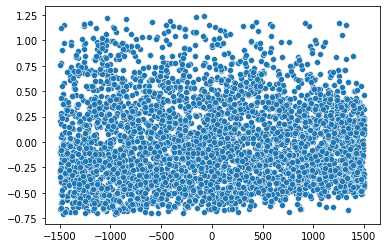

In [78]:
pca=PCA(n_components=2)
a = pca.fit_transform(dataset)
sns.scatterplot(x=a[:,0],y=a[:,1])

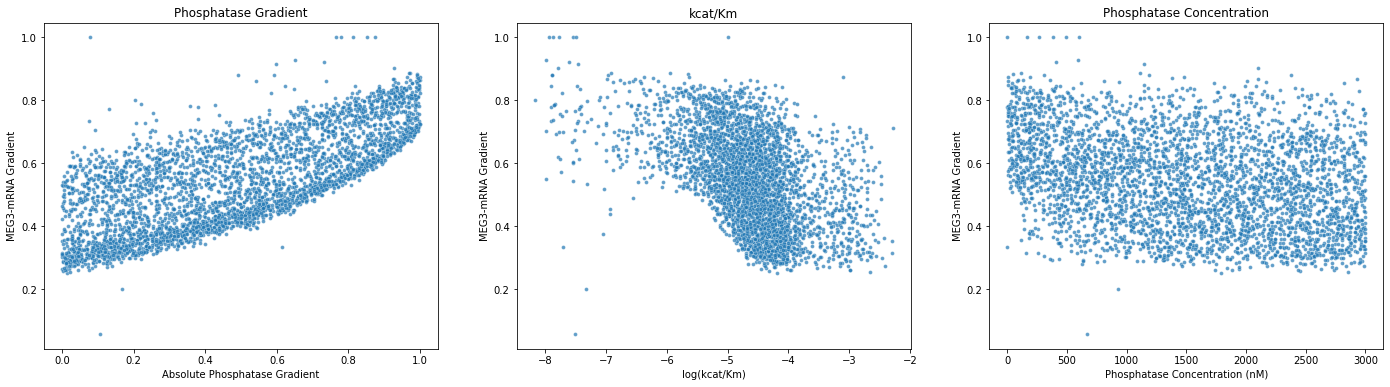

In [76]:
fig, ax =  plt.subplots(1,3,figsize=(24,6))
sns.scatterplot(data=dataset, x='abs_phosphatase_grad',y='meg3-rna_grad',ax=ax[0],s=15,alpha=0.7)
sns.scatterplot(data=dataset, x=np.log10(dataset['kcat/Km']),y='meg3-rna_grad',ax=ax[1],s=15,alpha=0.7)
sns.scatterplot(data=dataset, x='phosphatase_conc',y='meg3-rna_grad',ax=ax[2],s=15,alpha=0.7)
for i in range(3):
    ax[i].set_ylabel("MEG3-mRNA Gradient")
ax[0].set_xlabel("Absolute Phosphatase Gradient")
ax[0].set_title("Phosphatase Gradient")
ax[1].set_xlabel("log(kcat/Km)")
ax[1].set_title("kcat/Km")
ax[2].set_title("Phosphatase Concentration")
ax[2].set_xlabel("Phosphatase Concentration (nM)")
plt.savefig('plots/smoldyn_ml_training_data.pdf')

In [81]:
X = dataset[['abs_phosphatase_grad','kcat/Km','phosphatase_conc']]
y = dataset['meg3-rna_grad']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
svr = SVR(kernel='rbf', C=1, gamma='scale')
svr.fit(X_tr, y_tr)
y_pred = svr.predict(X_te)
mse_svr = mean_squared_error(y_te, y_pred)
print(f'Mean Squared Error for SVR: {mse_svr}')
gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=42)
gb.fit(X_tr, y_tr)

# Make predictions on the test set
y_pred = gb.predict(X_te)

# Evaluate the model
mse = mean_squared_error(y_te, y_pred)
print(f"Mean Squared Error for GBR: {mse}")
'''
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,),activation='relu', max_iter=1000, random_state=42)
mlp_reg.fit(X_tr, y_tr)
y_pred = mlp_reg.predict(X_te)
mse_mlp = mean_squared_error(y_te, y_pred)
print(f'Mean Squared Error for MLP: {mse_mlp}')
'''


Mean Squared Error for SVR: 0.017949526879826688
Mean Squared Error for GBR: 0.0008777156194520272


"\nmlp_reg = MLPRegressor(hidden_layer_sizes=(100,),activation='relu', max_iter=1000, random_state=42)\nmlp_reg.fit(X_tr, y_tr)\ny_pred = mlp_reg.predict(X_te)\nmse_mlp = mean_squared_error(y_te, y_pred)\nprint(f'Mean Squared Error for MLP: {mse_mlp}')\n"

In [73]:
param_grid = {
    'n_estimators': [100, 200,1000],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.005, 0.01, 0.05,0.075]
}

regressor = GradientBoostingRegressor()

# Create GridSearchCV instance
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_tr, y_tr)

# Print the best hyperparameters and corresponding performance
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_te, y_te)
print("Test Set R^2 Score:", test_score)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
Best Negative Mean Squared Error: -0.0010310289533172318
Test Set R^2 Score: 0.9557025537602046


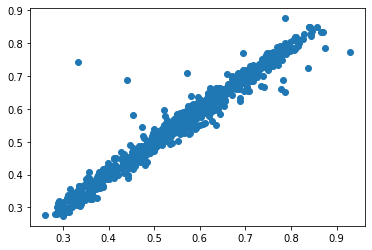

In [82]:
plt.scatter(y_te, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserW

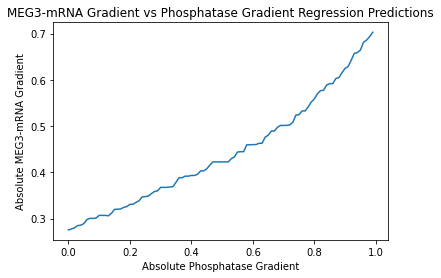

In [92]:
predictions = []
x_vals = []
for i in range(100):
    x_vals.append(i/100)
    x_to_pred = np.array([i/100,1.5e-4,2000]).reshape(1,-1)
    predictions.append(gb.predict(x_to_pred))
plt.plot(x_vals, predictions)
plt.ylabel('Absolute MEG3-mRNA Gradient')
plt.xlabel('Absolute Phosphatase Gradient')
plt.title('MEG3-mRNA Gradient vs Phosphatase Gradient Regression Predictions')
plt.savefig('plots/gbr_gradient_vs_gradient.pdf')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserW

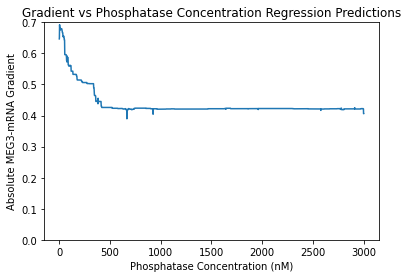

In [91]:
predictions = []
x_vals = []
for i in range(1,3000):
    x_vals.append(i)
    x_to_pred = np.array([0.5,1.5e-4,i]).reshape(1,-1)
    predictions.append(gb.predict(x_to_pred))
plt.plot(x_vals, predictions)
plt.ylim(0,0.7)
plt.ylabel('Absolute MEG3-mRNA Gradient')
plt.xlabel('Phosphatase Concentration (nM)')
plt.title('Gradient vs Phosphatase Concentration Regression Predictions')
plt.savefig('plots/gbr_phosphatase_conc.pdf')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:439: UserW

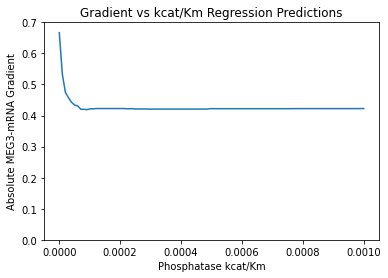

In [90]:
predictions = []
x_vals = []
vals = np.linspace(0,1e-3,100)
for i in range(100):
    x_vals.append(vals[i])
    x_to_pred = np.array([0.5,vals[i],2000]).reshape(1,-1)
    predictions.append(gb.predict(x_to_pred))
plt.plot(x_vals, predictions)
plt.ylim(0,0.7)
plt.ylabel('Absolute MEG3-mRNA Gradient')
plt.xlabel('Phosphatase kcat/Km')
plt.title('Gradient vs kcat/Km Regression Predictions')
plt.savefig('plots/gbr_kcat_Km.pdf')
plt.show()

Mean Squared Error (RBF Kernel): 0.19026912346817074
Mean Squared Error (MLP): 1.0031232893552555


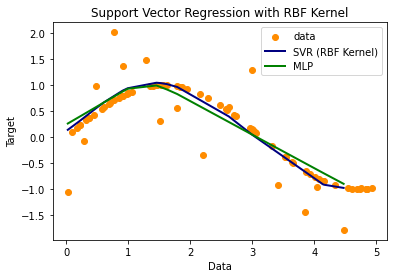

In [40]:
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(16))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_rbf.fit(X_train, y_train)

# Sort the test set for smooth plotting
X_test_sorted = np.sort(X_test, axis=0)

# Make predictions on the sorted test set
y_pred_rbf_sorted = svr_rbf.predict(X_test_sorted)

mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
mlp_regressor.fit(X_train, y_train)
y_pred_mlp_sorted = mlp_regressor.predict(X_test_sorted)
# Evaluate the model
mse_rbf = mean_squared_error(y_test, svr_rbf.predict(X_test))
print(f"Mean Squared Error (RBF Kernel): {mse_rbf}")
mse_mlp = mean_squared_error(y_test, y_pred_mlp_sorted)
print(f'Mean Squared Error (MLP): {mse_mlp}')

# Plot the results
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_test_sorted, y_pred_rbf_sorted, color='navy', lw=2, label='SVR (RBF Kernel)')
plt.plot(X_test_sorted, y_pred_mlp_sorted, color='green', lw=2, label='MLP')
plt.title('Support Vector Regression with RBF Kernel')
plt.xlabel('Data')
plt.ylabel('Target')
plt.legend()
plt.show()

Mean Squared Error (RBF Kernel): 0.19026912346817074


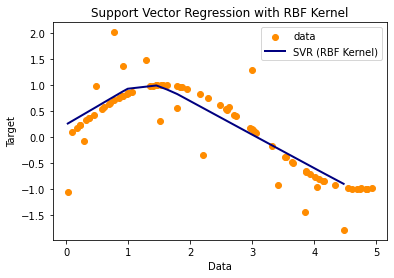

In [23]:
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(16))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
mlp_regressor.fit(X_train, y_train)

# Sort the test set for smooth plotting
X_test_sorted = np.sort(X_test, axis=0)

# Make predictions on the sorted test set
y_pred_mlp_sorted = mlp_regressor.predict(X_test_sorted)

# Evaluate the model
mse_rbf = mean_squared_error(y_test, svr_rbf.predict(X_test))
print(f"Mean Squared Error (RBF Kernel): {mse_rbf}")

# Plot the results
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_test_sorted, y_pred_rbf_sorted, color='navy', lw=2, label='SVR (RBF Kernel)')
plt.title('Support Vector Regression with RBF Kernel')
plt.xlabel('Data')
plt.ylabel('Target')
plt.legend()
plt.show()